In [ ]:
%pip install numpy==2.0.0

# TRANSFORMER PARA PREVISÃO DE PREÇOS DE AÇÕES
# AUTORES: GABRIEL FRANÇA E ENEIA GAZITE
# UNIVERSIDADE FEDERAL DE UBERLÂNDIA
# ÚLTIMA ATUALIZAÇÃO: 15/06/2025

Note: you may need to restart the kernel to use updated packages.


In [1]:
# === ETAPA 1: Importações ===
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [58]:
# === ETAPA 2: Carregamento e pré-processamento dos dados ===
paths = {
    "AAPL": "../data/Historical_Data_APPL_1Y.csv",
    #"GOOGL": "../data/Historical_Data_GOOGL_1Y.csv",
    #"IBM": "../data/Historical_Data_IBM_1Y.csv",
    #"MSFT": "../data/Historical_Data_MSFT_1Y.csv"
}

In [59]:
# Instanciar lista para armazenar os dataframes
dataframes = []

# Ler items e adicionar coluna da Empresa de origem
for ticker, path in paths.items():
    print(f"Lendo dados de {ticker} do caminho: {path}")
    df = pd.read_csv(path)
    df["Empresa"] = ticker
    dataframes.append(df)

# Mapeamento de empresas para valores - enumerar as empresas
empresa_map = {"AAPL": 0, "GOOGL": 1, "IBM": 2, "MSFT": 3}

# Converter a coluna 'Empresa' para valores numéricos
for df in dataframes:
    df["Empresa"] = df["Empresa"].map(empresa_map)

# Concatenar todos os dados
merged_df = pd.concat(dataframes, ignore_index=True)

# Mostrar as primeiras linhas do dataframe combinado
merged_df.head(50)

Lendo dados de AAPL do caminho: ../data/Historical_Data_APPL_1Y.csv


,Date,Close/Last,Volume,Open,High,Low,Empresa
0,05/29/2025,$199.95,51477940,$203.575,$203.81,$198.51,0
1,05/28/2025,$200.42,45339680,$200.59,$202.73,$199.90,0
2,05/27/2025,$200.21,56288480,$198.30,$200.74,$197.43,0
3,05/23/2025,$195.27,78432920,$193.665,$197.70,$193.46,0
4,05/22/2025,$201.36,46742410,$200.71,$202.75,$199.70,0
5,05/21/2025,$202.09,59211770,$205.17,$207.04,$200.71,0
6,05/20/2025,$206.86,42496640,$207.67,$208.47,$205.03,0
7,05/19/2025,$208.78,46140530,$207.91,$209.48,$204.26,0
8,05/16/2025,$211.26,54737850,$212.36,$212.57,$209.77,0
9,05/15/2025,$211.45,45029470,$210.95,$212.96,$209.54,0


In [64]:
# LIMPEZA E PREPARAÇÃO DOS DADOS

# Remover espaços em branco e substituir barras por underlines nos nomes das colunas
merged_df.columns = merged_df.columns.str.replace(' ', '').str.replace('/', '_')

cols_to_clean = ['Close_Last', 'Open', 'High', 'Low']
for col in cols_to_clean:
    merged_df[col] = merged_df[col].replace('[\\$,]', '', regex=True).astype(float)

# Garantir que as colunas de data estejam no formato correto
merged_df['Volume'] = merged_df['Volume'].astype(float)
merged_df['Empresa'] = merged_df['Empresa'].astype(int) 

# Verifique a tipagem dos dados
print(merged_df.dtypes)

# Seleção das features relevantes
features = merged_df[['Open', 'High', 'Low', 'Close_Last', 'Volume','Empresa']].copy()

# Remover linhas com valores ausentes
features = features.dropna()

# Verificar os outliers usando z-scores
z_scores = np.abs(zscore(features))
# Remover outliers com base nos z-scores, usar somente quando concatenar múltiplas empresas
#features = features[(z_scores < 3).all(axis=1)]

# Normalização dos dados
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)
#print(f"Dados normalizados: {scaled_data}")

# Função para criar janelas de sequência temporal
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i:i+seq_len]
        y = data[i+seq_len][3]  # Posição 3 = 'Close_Last'
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Criação das sequências
seq_len = 30
X, y = create_sequences(scaled_data, seq_len)
#print(f"Shape de X: {X.shape}")
#print(f"Shape de y: {y}")

# Divisão dos dados para treinamento, validação e teste
train_size = int(0.70 * len(X))
val_size = int(0.15 * len(X))
#print(f"Tamanho do conjunto de treinamento: {train_size}")
#print(f"Tamanho do conjunto de validação: {val_size}")

# Definir os conjuntos de treinamento
X_train, y_train = X[:train_size], y[:train_size]

# Definir os conjuntos de validação
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]

# Definir os conjuntos de teste
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

Date           object
Close_Last    float64
Volume        float64
Open          float64
High          float64
Low           float64
Empresa         int64
dtype: object


In [65]:
# Verificação das dimensões dos conjuntos de treinamento, validação e teste
merged_df.head(), merged_df.tail(), X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

(         Date  Close_Last      Volume     Open    High     Low  Empresa
 0  05/29/2025      199.95  51477940.0  203.575  203.81  198.51        0
 1  05/28/2025      200.42  45339680.0  200.590  202.73  199.90        0
 2  05/27/2025      200.21  56288480.0  198.300  200.74  197.43        0
 3  05/23/2025      195.27  78432920.0  193.665  197.70  193.46        0
 4  05/22/2025      201.36  46742410.0  200.710  202.75  199.70        0,
            Date  Close_Last      Volume     Open     High       Low  Empresa
 246  06/04/2024      194.35  47471450.0  194.635  195.320  193.0342        0
 247  06/03/2024      194.03  50080540.0  192.900  194.990  192.5200        0
 248  05/31/2024      192.25  75158280.0  191.440  192.570  189.9100        0
 249  05/30/2024      191.29  49947940.0  190.760  192.180  190.6300        0
 250  05/29/2024      190.29  53068020.0  189.610  192.247  189.5100        0,
 (154, 30, 6),
 (154,),
 (33, 30, 6),
 (33,),
 (34, 30, 6),
 (34,))

In [66]:
# === ETAPA 3: Dataset e DataLoader ===
# Define a classe StockDataset baseada no PyTorch Dataset
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define os DataLoaders para treinamento, validação e teste
batch_size = 32
train_loader = DataLoader(StockDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(StockDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(StockDataset(X_test, y_test), batch_size=batch_size)

In [67]:
# === ETAPA 4: Modelo Transformer ===
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model=128, num_heads=8, num_layers=4, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_len, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=num_heads, dim_feedforward=128,
            dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = x + self.positional_encoding[:, :x.size(1)] # Adiciona codificação posicional
        x = self.transformer_encoder(x)
        x = x[:, -1, :]  # usa o último token da sequência
        return self.regressor(x)

input_dim = X_train.shape[2]
print(f"Dimensão de entrada do modelo: {input_dim}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeSeriesTransformer(input_dim=input_dim).to(device)

Dimensão de entrada do modelo: 6


In [68]:
# === ETAPA 5: Treinamento ===
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

num_epochs = 50

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb).squeeze()
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    
    train_losses.append(train_loss / len(train_loader))

    # Validação
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb).squeeze()
            val_loss += criterion(output, yb).item() * xb.size(0)
    val_losses.append(val_loss / len(val_loader))
    
    # Atualização do scheduler
    if 'scheduler' in locals():
        scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

c:\Users\G2000\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\loss.py:1042: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Epoch 1/50 | Train Loss: 109.1092 | Val Loss: 9.3701
Epoch 2/50 | Train Loss: 29.5491 | Val Loss: 5.6227
Epoch 3/50 | Train Loss: 15.8837 | Val Loss: 0.1170
Epoch 4/50 | Train Loss: 6.6349 | Val Loss: 0.2034
Epoch 5/50 | Train Loss: 3.6643 | Val Loss: 1.3176
Epoch 6/50 | Train Loss: 3.6297 | Val Loss: 0.2434
Epoch 7/50 | Train Loss: 2.4272 | Val Loss: 0.0685
Epoch 8/50 | Train Loss: 2.3893 | Val Loss: 0.4294
Epoch 9/50 | Train Loss: 2.4157 | Val Loss: 0.3500
Epoch 10/50 | Train Loss: 2.0199 | Val Loss: 0.1357
Epoch 11/50 | Train Loss: 2.0690 | Val Loss: 0.2783
Epoch 12/50 | Train Loss: 1.8406 | Val Loss: 0.2266
Epoch 13/50 | Train Loss: 1.6956 | Val Loss: 0.2943
Epoch 14/50 | Train Loss: 1.4196 | Val Loss: 0.1539
Epoch 15/50 | Train Loss: 1.3256 | Val Loss: 0.3149
Epoch 16/50 | Train Loss: 1.4067 | Val Loss: 0.1909
Epoch 17/50 | Train Loss: 1.2488 | Val Loss: 0.1255
Epoch 18/50 | Train Loss: 1.1351 | Val Loss: 0.2520
Epoch 19/50 | Train Loss: 1.1269 | Val Loss: 0.0722
Epoch 20/50 | Tra

========================AVALIAÇÃO DO MODELO===========================

 Avaliação do Modelo:
➡️ MSE  (Erro Quadrático Médio):      0.0025
➡️ RMSE (Raiz do Erro Quadrático):   0.0499
➡️ MAE  (Erro Absoluto Médio):       0.0411
➡️ R²   (Coeficiente de Determinação): 0.9012


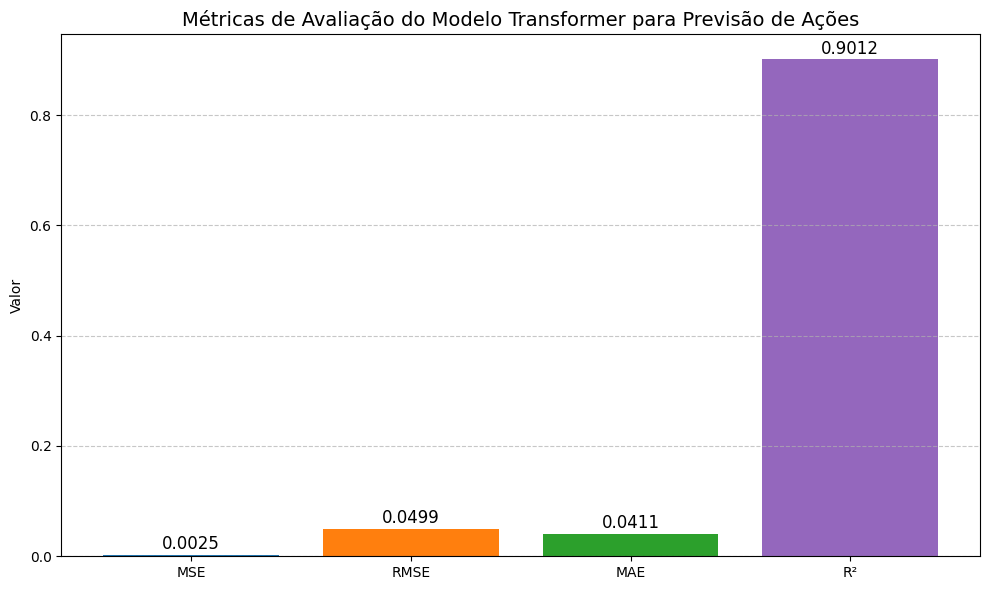

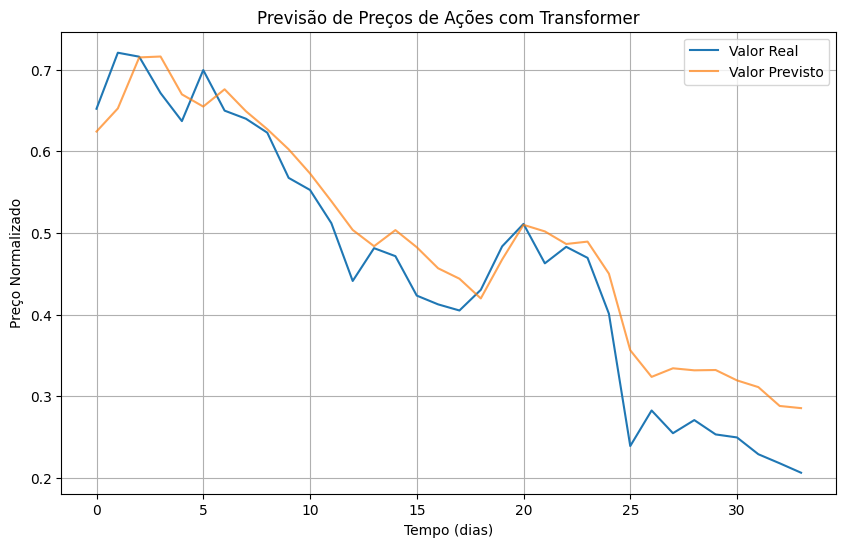

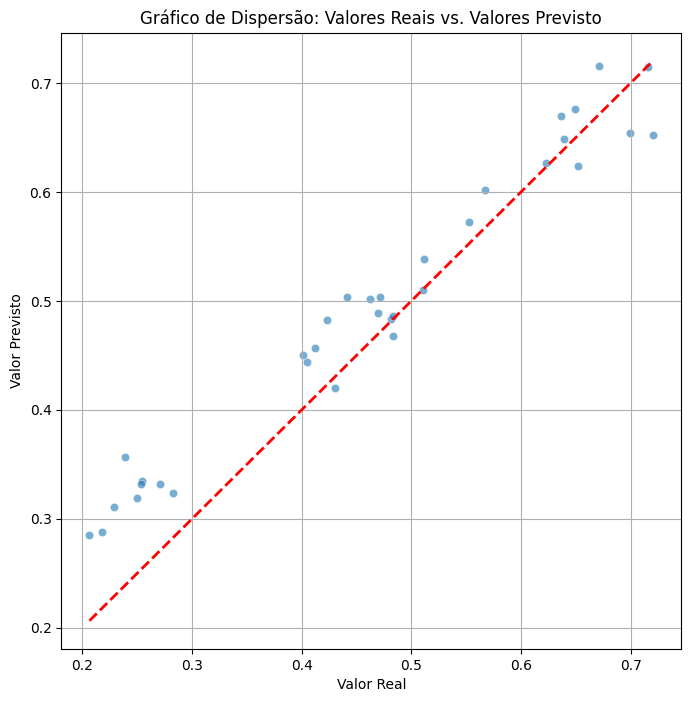

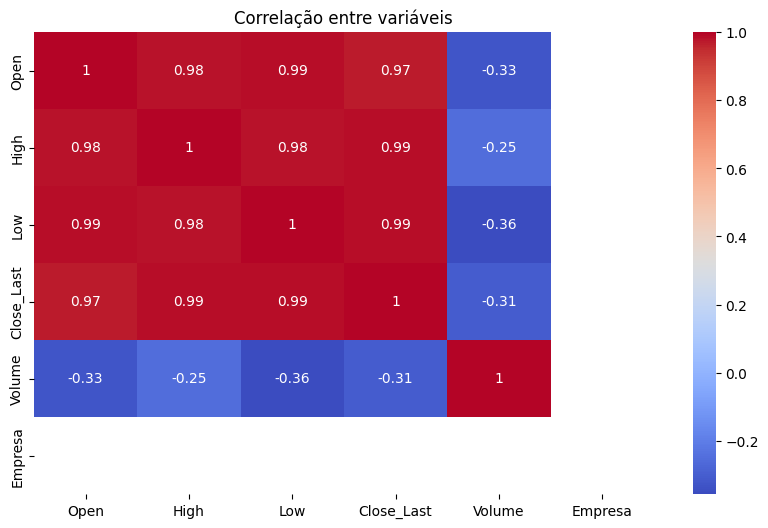

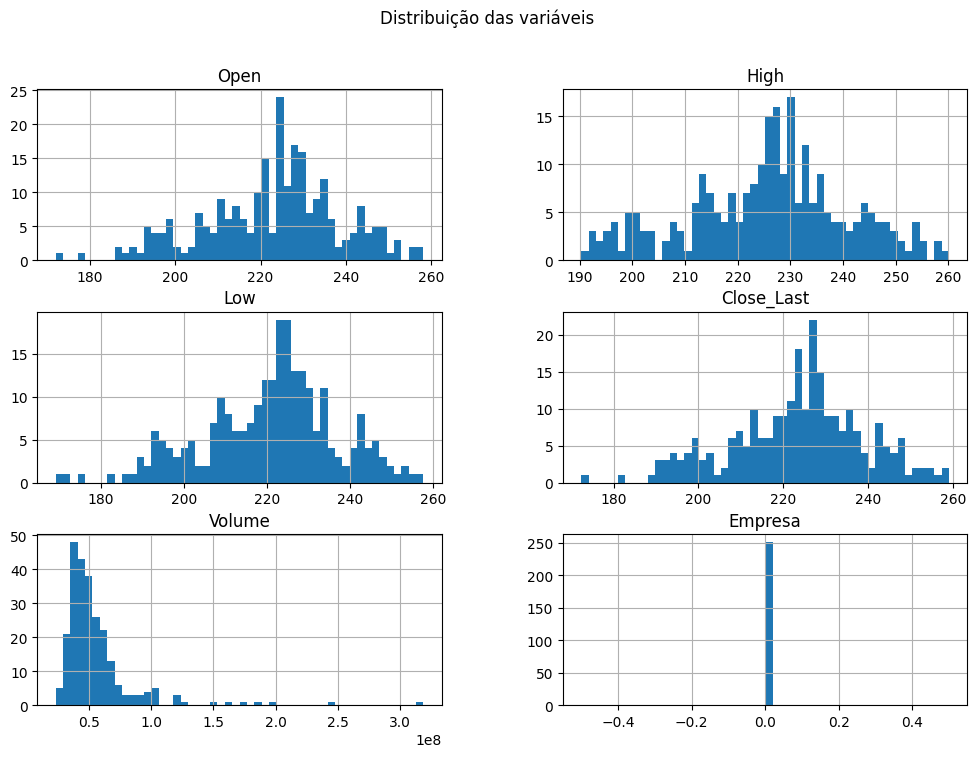

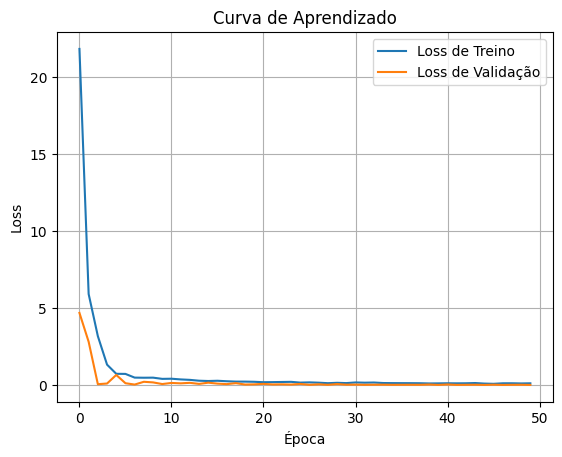

In [ ]:
# Avaliação final
# === ETAPA 6: Avaliação ===
print("========================AVALIAÇÃO DO MODELO===========================")
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        out = model(xb).squeeze()
        y_true.extend(yb.detach().cpu().view(-1).tolist())
        y_pred.extend(out.detach().cpu().view(-1).tolist())

# Métricas
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Mostrar métricas no console
print("\n Avaliação do Modelo:")
print(f"➡️ MSE  (Erro Quadrático Médio):      {mse:.4f}")
print(f"➡️ RMSE (Raiz do Erro Quadrático):   {rmse:.4f}")
print(f"➡️ MAE  (Erro Absoluto Médio):       {mae:.4f}")
print(f"➡️ R²   (Coeficiente de Determinação): {r2:.4f}")

#Gráfico de barras com as métricas
metrics = {
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "R²": r2
}

names = list(metrics.keys())
values = list(metrics.values())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd']

plt.figure(figsize=(10, 6))
bars = plt.bar(names, values, color=colors)
plt.title("Métricas de Avaliação do Modelo Transformer para Previsão de Ações", fontsize=14)
plt.ylabel("Valor")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar os valores numéricos acima das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.4f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# Visualização de valores reais vs. previstos
y_true = np.array(y_true)
y_pred = np.array(y_pred)

plt.figure(figsize=(10,6))
plt.plot(y_true, label='Valor Real')
plt.plot(y_pred, label='Valor Previsto', alpha=0.7)
plt.title("Previsão de Preços de Ações com Transformer")
plt.xlabel("Tempo (dias)")
plt.ylabel("Preço Normalizado")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de dispersão
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.title("Gráfico de Dispersão: Valores Reais vs. Valores Previsto")
plt.xlabel("Valor Real")
plt.ylabel("Valor Previsto")
plt.grid(True)
plt.show()


# === ETAPA 7: Análise Exploratória dos Dados (EDA) ===
# Ver correlação
plt.figure(figsize=(10,6))
sns.heatmap(features.corr(), annot=True, cmap='coolwarm')
plt.title('Correlação entre variáveis')
plt.show()

# Ver distribuição das variáveis
features.hist(bins=50, figsize=(12, 8))
plt.suptitle('Distribuição das variáveis')
plt.show()

# Ver curva de aprendizado
plt.plot(train_losses, label='Loss de Treino')
plt.plot(val_losses, label='Loss de Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Aprendizado')
plt.legend()
plt.grid(True)
plt.show()